<a href="https://www.kaggle.com/code/souviksaha4133x/notebook9aa671d47d?scriptVersionId=188025284" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Plant Disease Detection

***To create this detection model, we are using the PlantVillage dataset, specifically focusing on images in color. This dataset comprises 38 classes of plants.***

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import json
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from PIL import Image 

2024-07-12 21:42:42.620116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 21:42:42.620220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 21:42:42.754318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Import Libraries**

In [2]:
plant_village_dir = "/kaggle/input/plantvillage-dataset/color"
plant_doc_dir = "/kaggle/input/plantdoc-dataset/train"
dataset_dir = "/kaggle/working/dataset/"

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

batch_size = 32

In [3]:
print(os.listdir("/kaggle/input/plantvillage-dataset"))


print(len(os.listdir("/kaggle/input/plantvillage-dataset/color")))
print(os.listdir("/kaggle/input/plantvillage-dataset/color")[:5])


['segmented', 'grayscale', 'plantvillage dataset', 'color']
38
['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy']


In [4]:
print(len(os.listdir("/kaggle/input/plantvillage-dataset/color/Apple___Apple_scab")))
print(os.listdir("/kaggle/input/plantvillage-dataset/color/Apple___Apple_scab")[:5])

630
['5a178d63-372d-48c4-adb8-d616130ba3f0___FREC_Scab 3104.JPG', '8bcbb4fb-c733-4fc7-92d2-6e4a442e592e___FREC_Scab 3506.JPG', '2bc018ba-3c49-4cf4-9411-a93b7b196f45___FREC_Scab 3326.JPG', 'f18c0441-917e-4f34-b26e-a1a71d0adec2___FREC_Scab 3429.JPG', 'bc7769cc-805e-42ef-bbcf-0c134ff03276___FREC_Scab 2909.JPG']


**Data Preprocessing**

In [5]:
base_dir = '/kaggle/input/plantvillage-dataset/color'

(256, 256, 3)


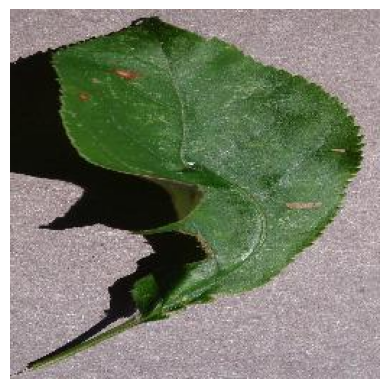

In [6]:

image_path = '/kaggle/input/plantvillage-dataset/color/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [7]:
image_path = '/kaggle/input/plantvillage-dataset/color/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img)

[[[154 138 141]
  [156 140 143]
  [152 136 139]
  ...
  [173 158 161]
  [165 150 153]
  [167 152 155]]

 [[152 136 139]
  [158 142 145]
  [157 141 144]
  ...
  [155 140 143]
  [155 140 143]
  [167 152 155]]

 [[147 131 134]
  [159 143 146]
  [159 143 146]
  ...
  [148 133 136]
  [150 135 138]
  [164 149 152]]

 ...

 [[ 83  71  73]
  [159 147 149]
  [185 173 175]
  ...
  [153 140 147]
  [173 160 167]
  [171 158 165]]

 [[164 152 152]
  [186 174 174]
  [174 162 162]
  ...
  [159 146 153]
  [157 144 151]
  [155 142 149]]

 [[148 137 135]
  [154 143 141]
  [143 131 131]
  ...
  [193 180 187]
  [178 165 172]
  [164 151 158]]]


**Train Test Split**

In [8]:
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    plant_village_dir ,
    image_size=(224,224),
    batch_size=32,
    seed = 123,
    validation_split=.2,
    subset='both'
)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Using 10861 files for validation.


**Model(Resnet)**

In [9]:
from tensorflow.keras.applications import ResNet50
# Load pre-trained ResNet-50 model without the top (fully connected) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained ResNet-50 layers
for layer in resnet_base.layers:
    layer.trainable = True

# Create the rest of your model
model = keras.Sequential([
    keras.layers.Rescaling(scale=1/255, input_shape=(224, 224, 3)),
    
    resnet_base,
    
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(38, activation='sigmoid')
])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                         

In [10]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

**Model Traning**

In [12]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1720820633.353903      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 [==============================] - 304s 193ms/step - loss: 1.2876 - accuracy: 0.6601 - val_loss: 1.1222 - val_accuracy: 0.6992
Epoch 2/10
1358/1358 [==============================] - 258s 190ms/step - loss: 0.3802 - accuracy: 0.8921 - val_loss: 0.5219 - val_accuracy: 0.8514
Epoch 3/10
1358/1358 [==============================] - 258s 190ms/step - loss: 0.2410 - accuracy: 0.9327 - val_loss: 0.3437 - val_accuracy: 0.9037
Epoch 4/10
1358/1358 [==============================] - 258s 190ms/step - loss: 0.1705 - accuracy: 0.9523 - val_loss: 0.2297 - val_accuracy: 0.9299
Epoch 5/10
1358/1358 [==============================] - 258s 190ms/step - loss: 0.1217 - accuracy: 0.9661 - val_loss: 0.1516 - val_accuracy: 0.9570
Epoch 6/10
1358/1358 [==============================] - 258s 190ms/step - loss: 0.0889 - accuracy: 0.9754 - val_loss: 0.1296 - val_accuracy: 0.9647
Epoch 7/10
1358/1358 [==============================] - 258s 189ms/step - loss: 0.0650 - accuracy: 0.9821 - val_loss: 0.131

**Model Evaluation**

In [13]:
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)
true_labels = [label for _, label in test_ds.unbatch()]
print(classification_report(true_labels, predicted_labels))

340/340 [==============================] - 20s 55ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       120
           1       1.00      0.98      0.99       124
           2       1.00      0.96      0.98        56
           3       0.99      1.00      1.00       348
           4       1.00      1.00      1.00       318
           5       1.00      1.00      1.00       208
           6       1.00      1.00      1.00       147
           7       0.81      0.94      0.87       109
           8       1.00      1.00      1.00       238
           9       0.96      0.88      0.92       200
          10       1.00      1.00      1.00       247
          11       0.99      1.00      0.99       229
          12       1.00      0.99      0.99       274
          13       1.00      1.00      1.00       219
          14       1.00      1.00      1.00        94
          15       1.00      1.00      1.00      1137
          16       1.00 

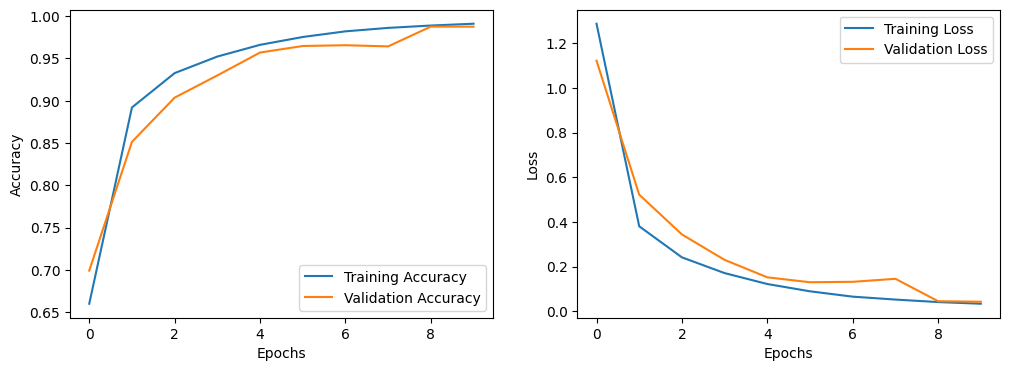

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Building a Predictive System**

In [15]:

def load_and_preprocess_image(image_path, target_size=(224, 224)):
   
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [16]:
class_names = train_ds.class_names

# Create the class_indices dictionary
class_indices = {i: name for i, name in enumerate(class_names)}

# If you need the reverse mapping (class name to index)
reverse_class_indices = {name: i for i, name in enumerate(class_names)}

In [17]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [18]:
json.dump(class_indices, open('class_indices.json', 'w'))

In [19]:
image_path = '/kaggle/input/plantvillage-dataset/color/Apple___Black_rot/02168189-aa75-4284-a7f0-8ca5901ea783___JR_FrgE.S 2948.JPG'

predicted_class_name = predict_image_class(model, image_path, class_indices)

print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 2s 2s/step
Predicted Class Name: Tomato___Late_blight


**Save the model**

In [20]:
path_to_model = "./res_model.h5"

model.save(path_to_model)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
